<a href="https://colab.research.google.com/github/JoanChege/CHATBOT1/blob/main/ModelFinal3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspellchecker
!pip install contractions
!pip install symspellpy
!pip install nltk contractions pyenchant

import json
import pickle
import numpy as np
import pandas as pd
import contractions
from contractions import contractions_dict
import re
from spellchecker import SpellChecker
from symspellpy import SymSpell, Verbosity
from wordcloud import STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.preprocessing.text import tokenizer_from_json

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.3-cp310-cp310-linux_x86_64.whl size=187457 sha256=9b4f8337301c9c360e412b2ebebdaa5deed71f81458a290b6ca6ae0d372a3f81
  Stored in directory: /root/.cache/pip/wheels/88/6a/a6/a1283cc145323a1fb3d475bd158ee60b248ab1985230d266fc
Successfully built editdistpy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 1.0 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
with open('/content/dataset3.json') as file:
   intents = json.load(file)

In [3]:
# Instantiate spell checker
spell = SpellChecker()

# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

words, documents = [], []

# Extract tags
tags = [intent['tag'] for intent in intents['intents']]
tags = list(set(tags))
tags = sorted(tags)

for intent in intents['intents']:
    for pattern in intent['patterns']:
        # Preprocess text
        pattern = re.sub(r'[^\w\s]', '', pattern)
        pattern = contractions.fix(pattern)
        pattern = pattern.lower()

        # Tokenization
        w_tokens = word_tokenize(pattern)

        # Spell correction
        corrected_words = [spell.correction(word) for word in w_tokens]

        # Filter nones
        corrected_words = [word for word in corrected_words if word]

        # Lemmatization
        lemmed = [lemmatizer.lemmatize(word) for word in corrected_words]

        words.extend(lemmed)
        documents.append((lemmed, intent['tag']))

        #if intent['tag'] not in tags:
            #tags.append(intent['tag'])

# Remove duplicates
words = list(set(words))

# Sort and save the words and tags
#words = sorted(words)
#tags = sorted(tags)

# Save to pickle files
pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(tags, open('tags.pkl', 'wb'))

In [4]:
# Create DataFrame
docs_x = [doc[0] for doc in documents]
docs_y = [doc[1] for doc in documents]

intents_df = pd.DataFrame()
intents_df['Patterns'] = docs_x
intents_df['Tags'] = docs_y

print(intents_df.head())

              Patterns      Tags
0                 [hi]  greeting
1                [hey]  greeting
2  [is, anyone, there]  greeting
3          [hi, there]  greeting
4              [hello]  greeting


In [5]:
# Create train data
train_data = []

for document in documents:

    # Bag of words for each document
    bag = []

    word_patterns = document[0]
    for word in words:
        if word in word_patterns:
            bag.append(1)
        else:
            bag.append(0)

    # Output row
    output_row = [0] * len(tags)

    # Set 1 for associated tag
    index = tags.index(document[1])
    output_row[index] = 1

    # Add to data
    train_data.append([bag, output_row])

In [6]:
# Create DataFrame
X = [data[0] for data in train_data]
y = [data[1] for data in train_data]
df = pd.DataFrame({'Patterns': X, 'Tags': y})

In [7]:
df

,Patterns,Tags
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
5986,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5987,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5988,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5989,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
# Assuming you have already created the DataFrame
X = df['Patterns'].tolist()
y = df['Tags'].tolist()

# Check the shape of X and y
print("Shape of X:", np.array(X).shape)
print("Shape of y:", np.array(y).shape)

Shape of X: (5991, 9674)
Shape of y: (5991, 318)


In [9]:
# Dataset splitting into train, validate, and test
np.random.shuffle(train_data)
train_index = int(len(train_data) * 0.8)
val_index = int(len(train_data) * 0.9)

train_x = [data[0] for data in train_data[:train_index]]
train_y = [data[1] for data in train_data[:train_index]]

val_x = [data[0] for data in train_data[train_index:val_index]]
val_y = [data[1] for data in train_data[train_index:val_index]]

test_x = [data[0] for data in train_data[val_index:]]
test_y = [data[1] for data in train_data[val_index:]]

In [10]:
train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

print(train_x.size)
print(val_x.size)
print(test_x.size)


46357808
5794726
5804400


In [13]:
# Add an axis to represent the sequence length
train_x = np.expand_dims(train_x, axis=1)
train_y = np.array(train_y)

# Similarly, add an axis for val_x and test_x
val_x = np.expand_dims(val_x, axis=1)
val_y = np.array(val_y)

test_x = np.expand_dims(test_x, axis=1)
test_y = np.array(test_y)

# Remove unnecessary singleton dimensions from train_x
train_x = np.squeeze(train_x)
train_y = np.array(train_y)

# Remove unnecessary singleton dimensions from val_x
val_x = np.squeeze(val_x)
val_y = np.array(val_y)

# Remove unnecessary singleton dimensions from test_x
test_x = np.squeeze(test_x)
test_y = np.array(test_y)


In [14]:
# Verify shapes
print("Shape of train_x:", train_x.shape)
print("Shape of train_y:", train_y.shape)
print("Shape of val_x:", val_x.shape)
print("Shape of val_y:", val_y.shape)
print("Shape of test_x:", test_x.shape)
print("Shape of test_y:", test_y.shape)

Shape of train_x: (4792, 9674)
Shape of train_y: (4792, 318)
Shape of val_x: (599, 9674)
Shape of val_y: (599, 318)
Shape of test_x: (600, 9674)
Shape of test_y: (600, 318)


In [15]:
vocab_size = len(words)
max_sequence_length = max([len(x) for x in train_x])
num_classes = len(tags)

In [18]:
# Define the model
model = Sequential()
# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length))
model.add(LSTM(units=256, activation='tanh', kernel_regularizer=l2(0.01), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=128, activation='tanh', kernel_regularizer=l2(0.01), return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 9674, 100)         967400    
                                                                 
 lstm_2 (LSTM)               (None, 9674, 256)         365568    
                                                                 
 dropout_3 (Dropout)         (None, 9674, 256)         0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)               

In [26]:
# List of learning rates to experiment with
learning_rates = [0.1, 0.01, 0.001, 0.0001]


for lr in learning_rates:
    # Create optimizer with the current learning rate
    opt = Adam(learning_rate=lr)

    # Compile the model with the current optimizer
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [27]:
# Training with early stopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [28]:
model_hist = model.fit(train_x, train_y,
          epochs=50,
          batch_size=64,
          validation_data=(val_x, val_y),
          callbacks=[early_stop])

Epoch 1/50
75/75 [==============================] - 94s 1s/step - loss: 7.5962 - accuracy: 0.8170 - val_loss: 5.5525 - val_accuracy: 0.8982
Epoch 2/50
75/75 [==============================] - 89s 1s/step - loss: 5.3658 - accuracy: 0.8923 - val_loss: 4.5079 - val_accuracy: 0.8982
Epoch 3/50
75/75 [==============================] - 90s 1s/step - loss: 4.4563 - accuracy: 0.8940 - val_loss: 3.8444 - val_accuracy: 0.8982
Epoch 4/50
75/75 [==============================] - 90s 1s/step - loss: 3.7808 - accuracy: 0.8944 - val_loss: 3.3108 - val_accuracy: 0.8982
Epoch 5/50
75/75 [==============================] - 90s 1s/step - loss: 3.2757 - accuracy: 0.8944 - val_loss: 2.8876 - val_accuracy: 0.8982
Epoch 6/50
75/75 [==============================] - 90s 1s/step - loss: 2.8578 - accuracy: 0.8942 - val_loss: 2.5609 - val_accuracy: 0.8982
Epoch 7/50
75/75 [==============================] - 90s 1s/step - loss: 2.5665 - accuracy: 0.8944 - val_loss: 2.2894 - val_accuracy: 0.8982
Epoch 8/50
75/75 [==

In [29]:
model.save("chatbot_model.h5")
print('Done')

Done


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


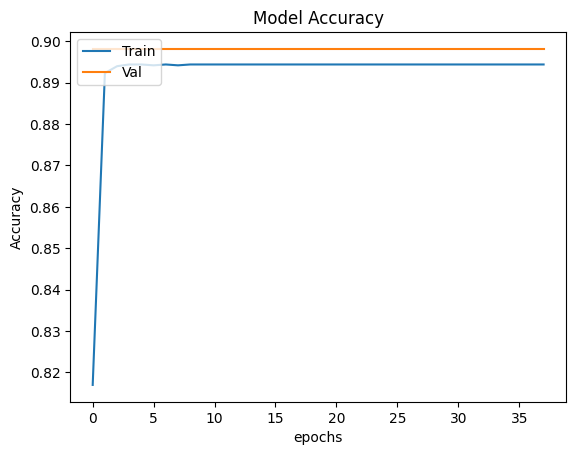

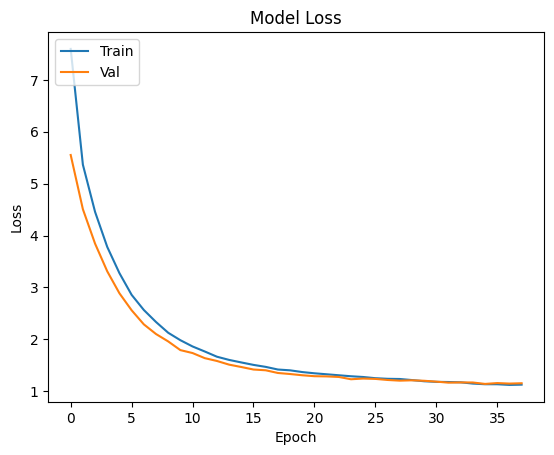

In [30]:
def plot(history):
    #Plot accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot(model_hist)

In [31]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_x, test_y)

# Print results
print(f"Learning Rate: {lr}")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print("\n")

19/19 [==============================] - 6s 288ms/step - loss: 1.2071 - accuracy: 0.8950
Learning Rate: 0.0001
Test Loss: 1.2070599794387817
Test Accuracy: 0.8949999809265137




In [32]:
#Evaluate the model on validation data using accuracy, precision, recall and F1score
predictions = model.predict(val_x)
predicted_labels = np.argmax(predictions, axis=1)

# Assuming val_y is a multilabel-indicator array
val_y_single_label = np.argmax(val_y, axis=1)


# Calculate accuracy, precision, recall, and f1 score
accuracy = accuracy_score(val_y_single_label, predicted_labels)
precision = precision_score(val_y_single_label, predicted_labels, average='weighted', zero_division=1)
recall = recall_score(val_y_single_label, predicted_labels, average='weighted')
f1 = f1_score(val_y_single_label, predicted_labels, average='weighted')

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


19/19 [==============================] - 6s 282ms/step
Accuracy: 0.8981636060100167
Precision: 0.9085342571508997
Recall: 0.8981636060100167
F1 Score: 0.8499771680446596


In [33]:
#find input model shape
# Load your model
model = load_model('chatbot_model.h5')

# Get the input shape of the model
input_shape = model.layers[0].input_shape
print("Model Input Shape:", input_shape)

Model Input Shape: (None, 9674)


In [34]:
with open('tags.pkl', 'rb') as f:
    tags = pickle.load(f)

print(len(tags))
print(tags[:5]) # print first 5 tags

318
['', ' ', ' brain', ' depressed', ' no']


In [35]:
# Load the pre-trained model
model = load_model('chatbot_model.h5')

#tags = [
   # 'depressed',
    #'greeting',
    #'sad',]


with open('tags.pkl', 'rb') as f:
    tags = pickle.load(f)


# Assuming the model input shape is (None, 9674), adjust the input accordingly
input_text = input("You: ")

# Preprocess input
input_words = nltk.word_tokenize(input_text)
input_words = [lemmatizer.lemmatize(word.lower()) for word in input_words]

# Create bag of words representation
bag_of_words = []

for word in words:
    if word in input_words:
        bag_of_words.append(1)
    else:
        bag_of_words.append(0)

# Ensure the input shape matches the model's input shape
input_arr = np.expand_dims(bag_of_words, axis=0)

print("Input shape:", input_arr.shape)

# Make prediction
prediction = model.predict(input_arr)[0]

# Check the shapes
print("Prediction shape:", prediction.shape)
print("Number of classes in the model:", prediction.shape[0])
print("Tags length:", len(tags))

# Ensure that the number of classes in the model matches the length of the tags list
if prediction.shape[0] == len(tags) and prediction.shape[0] > 0:
    predicted_tag = tags[np.argmax(prediction)]
    confidence = max(prediction)
    print("Predicted tag:", predicted_tag)
    print("Confidence:", confidence)
else:
    print("Number of classes in the model doesn't match the length of the tags list.")


You: hello
Input shape: (1, 9674)
1/1 [==============================] - 1s 895ms/step
Prediction shape: (318,)
Number of classes in the model: 318
Tags length: 318
Predicted tag:  
Confidence: 0.9454184


In [38]:
# Load resources
lemmatizer = WordNetLemmatizer()
model = load_model('chatbot_model.h5')
with open('tags.pkl', 'rb') as f:
    tags = pickle.load(f)

with open('words.pkl', 'rb') as f:
   all_words = pickle.load(f)

# Preprocessing functions
def preprocess(input_text):
    input_words = nltk.word_tokenize(input_text)
    input_words = [lemmatizer.lemmatize(word.lower()) for word in input_words]
    return input_words

def bag_of_words(input_words):

    bag = [0] * len(all_words)
    # all_words would be the full vocabulary

    for word in input_words:
        if word in all_words:
            bag[all_words.index(word)] += 1

    return np.array(bag)

# Prediction function
def predict_class(input_text):

    # Preprocess input text
    input_words = preprocess(input_text)

    # Bag of words
    input_arr = bag_of_words(input_words)

    # Add batch dimension
    input_arr = np.expand_dims(input_arr, axis=0)

    # Make prediction
    prediction = model.predict(input_arr)[0]

    # Decode prediction
    predicted_tag = tags[np.argmax(prediction)]
    confidence = max(prediction)

    print("Predicted tag:", predicted_tag)
    print("Confidence:", confidence)


# Test input
input_text = input("You: ")
predict_class(input_text)

You: i am sad


1/1 [==============================] - 1s 857ms/step
Predicted tag:  
Confidence: 0.9454184
